In [1]:
import sys,os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import scipy as sp
from scipy.linalg import pinv as spinv
from sklearn.metrics import pairwise_distances

In [2]:
# convert s[l,n] --> ops[l,nx] = {s[l,n], s[l,i]*s[l,j]} (j>i)
def operators(s):
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))
    
    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1
    
    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [3]:
def generate_seqs(n_var,n_seq,n_sample=30):
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    n_ops = ops.shape[1]

    w_true = (np.random.rand(n_ops)-0.5)/np.sqrt(float(n_var))

    sample_energy = ops.dot(w_true)
    p = np.exp(sample_energy)
    p = p/np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [4]:
def eps_machine_step(w,ops,eps_scale,alpha):
    obs_energies_w = ops.dot(w)
    sec_order = np.tanh(w*eps_scale)
    probs_w = obs_energies_w*(eps_scale-1)
    max_obs = np.max(probs_w)
    probs_w = np.exp(probs_w - max_obs)
    probs_w /= np.sum(probs_w)
    ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
    
    return alpha*(ops_expect_w - sec_order)

In [5]:
def log_prob_given(s,col,w):
    s_temp = np.copy(s)
    s_temp[:,col] = -s_temp[:,col]
    
    return np.log(1.0/(1.0 + np.exp(operators(s_temp).dot(w)-operators(s).dot(w))))

In [6]:
def tau_update(n_seq,n_var,ops,w):
    sigma_i = ops[:,:n_var]
    
    energy_orig = ops.dot(w)
    prob_sigma_fake = 0.0
    prob_sigma_orig = 0.0
    s_temp1,s_new = np.copy(ops[:,:n_var]),np.copy(ops[:,:n_var])
    for col in range(n_var):        
        s_temp = np.copy(ops[:,:n_var])
        s_temp[:,col] = np.random.choice([1,-1],size=(n_seq))
        
        #prob_flip = 1.0/(1.0+np.exp(energy_orig - operators(s_temp).dot(w)))
        
        # 2019.07.21: Tai
        prob_flip = np.exp(energy_orig - operators(s_temp).dot(w))
        
        rand_choice = prob_flip > np.random.rand(n_seq)
        
        s_temp1[rand_choice,col] = s_temp[rand_choice,col]
        s_new[rand_choice,col] = s_temp[rand_choice,col]
        
        prob_sigma_fake += np.mean(log_prob_given(s_temp1,col,w))
        s_temp1 = np.copy(ops[:,:n_var])
        prob_sigma_orig += np.mean(log_prob_given(s_temp1,col,w))
    ops_new = operators(s_new)
    return operators(s_temp),ops_new,prob_sigma_orig-prob_sigma_fake

In [7]:
def eps_machine_rbm_EM(s,eps=0.01,max_iter=50,alpha=0.5):    
    np.random.seed(13)
    ops = operators(s)    
    n_ops = n_var+int((n_var-1)*n_var*0.5)
        
    w = np.random.rand(n_ops) - 0.5    
    for iterate in range(max_iter):
        w += eps_machine_step(w,ops,eps,alpha)            
        
    return w

In [8]:
n_var,n_seq = 20,5000
np.random.seed(0)

w_true,s = generate_seqs(n_var,n_seq)

In [9]:
alpha = 0.5
n_part = 5000
eps_list = [0.5]

n_ops = n_var+int((n_var-1)*n_var/2)

w = np.zeros((n_ops,len(eps_list)))             
for i,eps in enumerate(eps_list):
    print(i,eps)
    w[:,i] = eps_machine_rbm_EM(s[:n_part],eps=eps,max_iter=30,alpha=alpha)

0 0.5


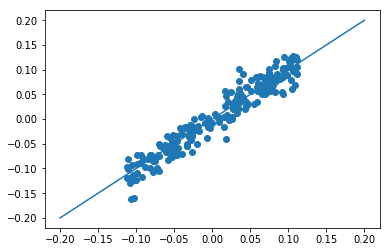

In [10]:
#plt.title('eps = %s'%eps)
plt.plot([-0.2,0.2],[-0.2,0.2])
plt.scatter(w_true,w[:,0])

In [11]:
#plt.plot([-0.2,0.2],[-0.2,0.2])
#plt.scatter(w_true,w[:,1])

In [12]:
#plt.plot([-0.2,0.2],[-0.2,0.2])
#plt.scatter(w_true,w[:,2])